# IPLBot-RASA

# Como construir e fazer deploy de um Chatbot utilizando Rasa (utilizando estudo de caso IPL)

Entendendo um pouco da estrutura do nosso chatbot

![image1.png](../images/image1.png)

Vamos detalhar essa arquitetura (continue consultando a imagem para entender isso):

    * Assim que Rasa recebe uma mensagem do usuário final, ele tenta prever ou extrair a "intenção" e as "entidades" presentes na mensagem. Esta parte é tratada por Rasa NLU
    * Depois que a intenção do usuário é identificada, o Rasa Stack executa uma ação chamada action_match_news para obter as atualizações da última correspondência de IPL
    * Rasa então tenta prever o que deve fazer a seguir. Esta decisão é tomada considerando vários fatores e é tratada pelo Rasa Core
    * No nosso exemplo, Rasa está mostrando o resultado da correspondência mais recente para o usuário. Também previu a próxima ação que nosso modelo deve executar - para verificar com o usuário se o chatbot conseguiu resolver sua consulta

# Configurando o IPL Chatbot

Practice Version – use esta versão ao ler este artigo. Isso ajudará você a entender como o código funciona

Então, vá em frente e clone o projeto 'Practice Version' do GitHub:

```
git clone https://github.com/ClaudioLSilva/IPLBot-chatbot-with-RASA.git && cd IPLBot-chatbot-with-RASA
```

E entre (cd) na practice_version:

```
cd practice_version
```

Uma observação rápida sobre algumas coisas que você deve estar ciente antes de prosseguir:

- Atualmente, o Rasa suporta apenas a versão Python <= 3.6. Se você possui uma versão superior do Python, pode configurar um novo ambiente no conda usando o seguinte comando:

```
conda create -n rasa python=3.6
conda activate rasa
```

- Você precisará de um editor de texto para trabalhar com os vários arquivos do nosso projeto. O meu favorito é o Sublime Text, que você pode baixar [aqui](https://www.sublimetext.com/)

# Instalando o Rasa e suas dependências

Você pode usar o código abaixo para instalar todas as dependências do Rasa Stack:

```
pip install -r requirements.txt
```

Esta etapa pode levar alguns minutos, pois existem alguns arquivos para instalar. Você também precisará instalar um modelo de idioma spaCy em inglês:

```
python -m spacy download en
```

Mãos à obra!

# Extraindo a intenção do usuário de uma mensagem

A primeira coisa que queremos fazer é descobrir a intenção do usuário. O que ele ou ela deseja realizar? Vamos utilizar o Rasa e criar um modelo de NLU para identificar a intenção do usuário e suas entidades relacionadas.

Examine a pasta practice_version que você baixou anteriormente:

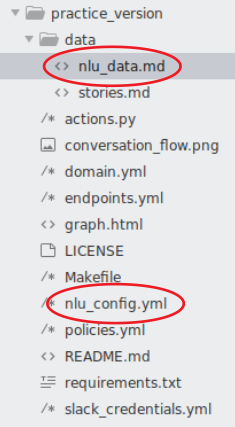

Os dois arquivos que usaremos estão destacados acima.

**data/nlu_data.md** - Esse é o arquivo no qual você salvará seus dados de treinamento para extrair a intenção do usuário. Já existem alguns dados no arquivo:

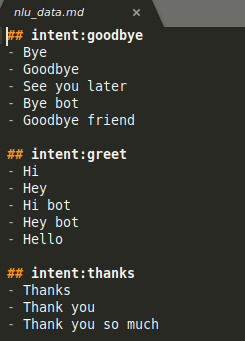

Como você pode ver, o formato dos dados de treinamento para 'intenção' é bastante simples em Rasa. Você só tem de:

* Começar a linha com "## intent: intent_name"
* Fornecer todos os exemplos nas seguintes linhas

Vamos escrever alguns exemplos de intenções em Python para o cenário em que o usuário deseja obter atualizações de IPL:

```
## intent:current_matches
- which cricket match is happening right now 
- which ipl match is next 
- which teams are playing next in ipl 
- tell me some ipl news 
- i want ipl updates 
- what are the latest match updates 
- who won the last ipl match 
- how is ipl going 
- what was the result of the last match 
- when is the next match
```

Você pode incluir quantos exemplos desejar para cada intenção. De fato, certifique-se de incluir gírias e formas curtas que você usa ao enviar mensagens de texto. A idéia é fazer o chatbot entender a maneira como digitamos o texto. Sinta-se à vontade para consultar a versão completa, em que dei muitos exemplos para cada tipo de intenção.

* **nlu_config.yml** - Este arquivo permite criar um pipeline de processamento de texto em Rasa. Felizmente para nós, o Rasa vem com duas configurações padrão com base na quantidade de dados de treinamento que temos:
 * Pipeline "spacy_sklearn" se você tiver menos de 1000 exemplos de treinamento
 * "Tensorflow_embedding" se você tiver uma grande quantidade de dados

Vamos escolher o primeiro como ele se encaixa no nosso exemplo:

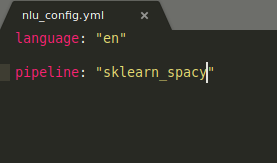

Porém, para ampliarmos o uso e a capacidade mais ampliada de interpretação, usaremos a seguinte, configuração:

nlu_config.yml
--------------
```
language: "en"

# pipeline: "spacy_sklearn"  <comentamos esta linha, pois abaixo as mesmas configurações estão embutidas>
pipeline:
  - name: "nlp_spacy"
  - name: "tokenizer_spacy"
  - name: "intent_featurizer_spacy"
  - name: "intent_classifier_sklearn"
  - name: "ner_crf"
  - name: "ner_synonyms"
```

# Treinando o classificador NLU

Se você chegou até aqui, já fez a maior parte do trabalho para o modelo de extração de intenção. Vamos treiná-lo e vê-lo em ação!

Você pode treinar o classificador simplesmente seguindo o comando abaixo:

```
make train-nlu
```
Usando o Windows? Você pode executar o seguinte código python:

```
python -m rasa_nlu.train -c nlu_config.yml --data data/nlu_data.md -o models --fixed_model_name nlu --project current --verbose
```

# Prever a intenção

Vamos testar o desempenho do nosso modelo, fornecendo um texto de exemplo no qual ele não foi treinado para extrair intenções. Você pode abrir um shell iPython / Python e siga as seguintes etapas:
```
>>> from rasa_nlu.model import Interpreter
>>> nlu_model = Interpreter.load('./models/current/nlu')
>>> nlu_model.parse('what is happening in the cricket world these days?')
```

Aqui está a aparência da saída:
```    
{
	'intent': {
	'name': 'current_matches',
	'confidence': 0.6657130383645372
	},
	'entities': [],
	'intent_ranking': [{
	'name': 'current_matches',
	'confidence': 0.6657130383645372
	}, {
	'name': 'goodbye',
	'confidence': 0.11589267701634796
	}, {
	'name': 'affirm',
	'confidence': 0.06372593552204527
	}, {
	'name': 'thanks',
	'confidence': 0.0623182164883462
	}, {
	'name': 'deny',
	'confidence': 0.05938353524001583
	}, {
	'name': 'greet',
	'confidence': 0.03296659736870796
	}],
	'text': 'what is happening in the cricket world these days?'
	}
```

O nosso modelo NLU não apenas tem um bom desempenho na extração de intenções, mas também classifica as outras intenções com base em seus índices de confiança. Este é um pequeno recurso bacana que pode ser realmente útil quando o classificador é confundido entre várias intenções.

# Fazendo conversas interativas

Um dos aspectos mais importantes de um aplicativo de chatbot é a capacidade de ser interativo. Lembre-se de um chatbot que você já usou antes. Nosso interesse naturalmente desperta se o chatbot é capaz de manter uma conversa, certo?

Espera-se que o chatbot extraia todas as informações necessárias para executar uma tarefa específica usando as conversas de vaivém com o usuário final.

# Projetando o fluxo conversacional

Reserve um momento para pensar na conversa mais simples que nosso chatbot pode ter com um usuário. Qual seria o fluxo dessa conversa? Vamos escrever na forma de uma história!

```
Me: Hi

Iplbot: Hey! How may I help you?

Me: What was the result of the last match?

Iplbot: Here are some IPL quick info:
1.The match between Rajasthan Royals and Delhi Capitals was recently held and Delhi Capitals won.
2.The next match is Warriors vs Titans on 22 April 2019

Iplbot: Did that help you?

Me: yes, thank you!

Iplbot: Glad that I could help! :)
```

Vamos ver como podemos ensinar uma conversa simples como essa para Rasa:

```
## news path 1
* greet
  - utter_greet
* current_matches
  - action_match_news
  - utter_did_that_help
* affirm or thanks
  - utter_gratitude
* goodbye
  - utter_goodbye
```

O formato geral é:

```
## news path 1           <--- nome da história para fins de depuração
* greet                  <--- intenção detectada do usuário
  - utter_greet          <--- que ação o bot deve executar
* current_matches        <--- a seguinte intenção na conversa
```

Isso é chamado de **caminho da história do usuário**. Forneci algumas histórias no arquivo **data/stories.md** para sua referência. Esses são os **dados de treinamento do Rasa Core**.

O modo como funciona é:

 * Dê alguns exemplos de caminhos de história de amostra que o usuário deve seguir
 * O Rasa Core os combina aleatoriamente para criar caminhos de usuário mais complexos
 * Em seguida, constrói um modelo probabilístico a partir disso. Este modelo é usado para prever a próxima ação que Rasa deve executar

Confira o arquivo **data/stories.md** na versão completa do projeto para mais exemplos. Enquanto isso, aqui está uma boa visualização dos caminhos básicos da história gerados por Rasa para o nosso chatbot IPL:

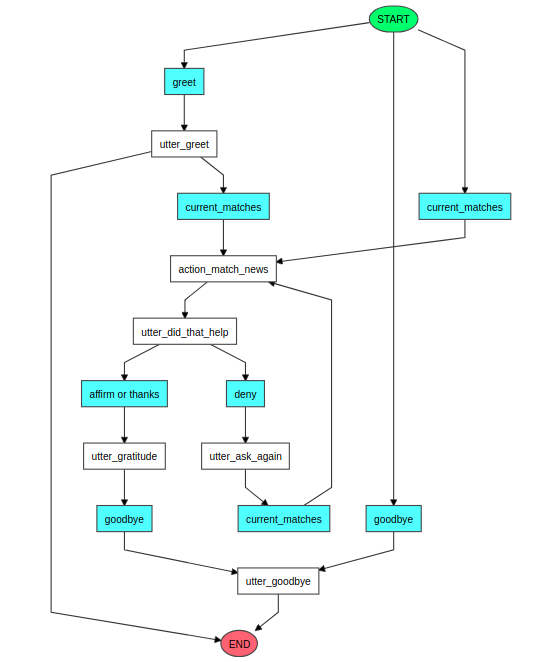

A ilustração acima pode parecer complicada, mas está simplesmente listando várias histórias possíveis de usuários que eu ensinei a Rasa. Aqui estão algumas coisas a serem observadas no gráfico acima:

* Exceto pelas caixas INICIAR e FIM, todas as caixas coloridas indicam a intenção do usuário
* Todas as caixas brancas são ações que o chatbot executa
* As setas indicam o fluxo da conversa
* **action_match_news** é onde atingimos o CricAPI para obter informações do IPL

Escreva o seguinte no seu arquivo stories.md:

```
## news path 1
* greet
  - utter_greet
* current_matches
  - action_match_news
  - utter_did_that_help
* affirm or thanks
  - utter_gratitude
* goodbye
  - utter_goodbye

## news path 2
* current_matches
  - action_match_news
  - utter_did_that_help
* affirm or thanks
  - utter_gratitude
* goodbye
  - utter_goodbye

## news path 3
* greet
  - utter_greet
* current_matches
  - action_match_news
  - utter_did_that_help
* deny
  - utter_ask_again
* current_matches
  - action_match_news
  - utter_did_that_help
* affirm or thanks
  - utter_gratitude
* goodbye
  - utter_goodbye

## greet path
* greet
  - utter_greet

## goodbye path
* goodbye
  - utter_goodbye
```

Agora, gere um gráfico semelhante para suas histórias usando o seguinte comando:

```
python -m rasa_core.visualize -d domain.yml -s data/stories.md -o graph.html
```

Porém, para facilitar, embuti no makefile este comando. Então você pode executá-lo mais facilmente assim:
```
make graph
```

**Isso é muito útil ao depurar** o fluxo conversacional do chatbot.

# Definindo o domínio

Agora, abra o arquivo **domain.yml**. Você estará familiarizado com a maioria dos recursos mencionados aqui:

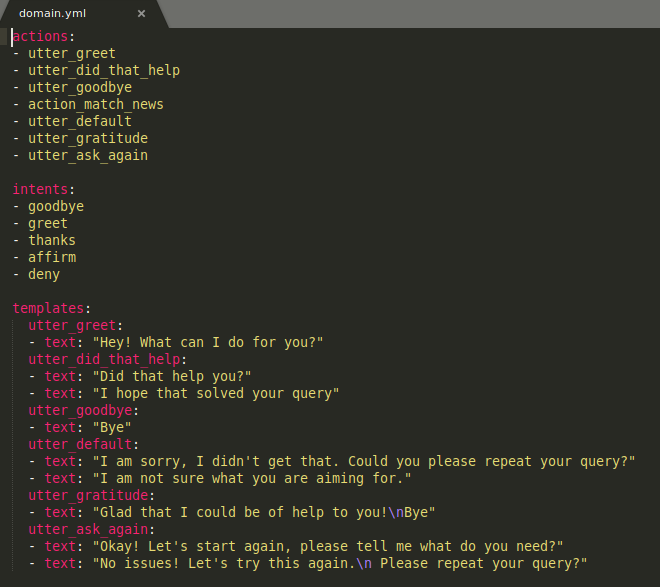

O domínio é o **mundo do seu chatbot**. Ele contém tudo o que o chatbot deve saber, incluindo:

* Todas as ações que é capaz de realizar
* As intenções que ele deve entender
* O modelo de todas as declarações que ele deve informar ao usuário e muito mais

# Definindo diretivas (Policies)

O Rasa Core gera os dados de treinamento para a parte conversacional usando as histórias que fornecemos. Também permite definir um conjunto de políticas a serem usadas ao decidir a próxima ação do chatbot. Essas políticas são definidas no arquivo **policies.yml**.

Então, abra esse arquivo e copie o seguinte código:

```
policies:
  - name: KerasPolicy
    epochs: 100
    max_history: 5
  - name: FallbackPolicy
    fallback_action_name: 'action_default_fallback'
  - name: MemoizationPolicy
    max_history: 5
```

Aqui estão algumas coisas a serem observadas sobre as políticas acima (extraídas das políticas do Rasa Core aqui):

* **O KerasPolicy** usa uma rede neural implementada no Keras para selecionar a próxima ação. A arquitetura padrão é baseada em um modelo LSTM (Long Short Term Term Memory)
* **MemoizationPolicy** memoriza as conversas nos seus dados de treinamento. Ele prevê a próxima ação com confiança 1.0, se essa conversa exata existir nos dados de treinamento, caso contrário, ela prevê 'Nenhuma' com confiança 0.0
* **FallbackPolicy** chama uma ação de fallback se o reconhecimento de intenção tiver confiança abaixo de nlu_threshold ou se nenhuma das políticas de diálogo prever uma ação com confiança maior que core_threshold
* Um hiperparâmetro importante para as políticas do Rasa Core é o **max_history**. Isso controla quanto histórico de diálogo o modelo examina para decidir qual ação tomar em seguida

>>>> Continua... **Prosseguirei a confecção do manual de instalação**